In [10]:
# Magic line to force reload all modules when this cell is run multiple times
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, os.path.expanduser("~/Developer/interpretDL/Pipeline"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import numpy as np
import pandas as pd
import umap

from ClusterPipeline import ClusterPipeline
from helper import split_valid, plot_confusion_matrix, plot_history
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder

RANDOM_STATE = 42
np.random.seed(seed=RANDOM_STATE) 

In [77]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.offline import plot
import ipywidgets as widgets

# %matplotlib widget
py.offline.init_notebook_mode(connected=True)

In [12]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.close("History")
    fig, axs = plt.subplots(1, 2, figsize=(16,8),num="History")

    # Plot training & validation accuracy values
    axs[0].grid(True)
    axs[0].plot(history.history['acc'])
    axs[0].plot(history.history['val_acc'])
    axs[0].set(title='Model accuracy', ylabel='Accuracy', xlabel='Epoch')
    axs[0].legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    axs[1].grid(True)
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set(title='Model loss',ylabel='Loss', xlabel='Epoch')
    axs[1].legend(['Train', 'Test'], loc='upper left')

    plt.show()

In [13]:
fname = "data/cleaned_SA_Sub.csv"
raw_data = pd.read_csv(fname, index_col=0)
raw_data.head()

,ASD_DX_group,Risk,ROI01,ROI02,ROI03,ROI04,ROI05,ROI06,ROI07,ROI08,...,LeftCaudate,RightCaudate,LeftHippocapus,RightHippocapus,LeftGlobusPall,RightGlobusPall,LeftPutamen,RightPutamen,LeftThalamus,RightThalamus
CandID,,,,,,,,,,,,,,,,,,,,,
103430,TYPICAL,HR,529.158386,298.568665,190.627472,134.555801,363.573608,646.810547,33.957870,172.629700,...,2081,1987,1993,2071,781,783,2827,3068,5308,5483
107524,ASD,HR,518.345703,311.013794,118.777634,198.685638,477.074524,405.450134,55.401951,126.927612,...,1687,1798,1630,1480,510,525,2321,2230,4497,4574
108372,TYPICAL,LR,443.658081,156.824844,157.223099,147.381149,492.784088,305.069519,61.638298,136.602600,...,2229,2303,1803,1847,692,709,2839,2754,4666,4741
113320,TYPICAL,LR,529.817078,301.160583,129.092483,151.090851,395.564331,597.880981,32.048248,163.701218,...,2365,2314,1722,1669,670,660,2701,2776,4870,4891
114640,TYPICAL,LR,689.399170,303.337524,154.169434,98.182709,592.248962,364.648315,10.539658,142.580795,...,2096,2196,1929,2016,752,739,3023,3086,5187,5224


In [14]:
raw_data.shape

(336, 347)

In [15]:
raw_data["ASD_DX_group"].value_counts()

TYPICAL            249
ASD                 42
ATYPICAL_ADOS       24
ATYPICAL_MULLEN     11
FXS_NO               5
FXS_TYP              2
FXS_ASD              2
FXS_ATYP_MULLEN      1
Name: ASD_DX_group, dtype: int64

In [16]:
label_cols = ["ASD_DX_group", "Risk"]
noisy_cols = []

features = raw_data.drop(columns=noisy_cols+label_cols)
features.head()

,ROI01,ROI02,ROI03,ROI04,ROI05,ROI06,ROI07,ROI08,ROI09,ROI10,...,LeftCaudate,RightCaudate,LeftHippocapus,RightHippocapus,LeftGlobusPall,RightGlobusPall,LeftPutamen,RightPutamen,LeftThalamus,RightThalamus
CandID,,,,,,,,,,,,,,,,,,,,,
103430,529.158386,298.568665,190.627472,134.555801,363.573608,646.810547,33.957870,172.629700,58.659229,88.770279,...,2081,1987,1993,2071,781,783,2827,3068,5308,5483
107524,518.345703,311.013794,118.777634,198.685638,477.074524,405.450134,55.401951,126.927612,57.548630,43.613918,...,1687,1798,1630,1480,510,525,2321,2230,4497,4574
108372,443.658081,156.824844,157.223099,147.381149,492.784088,305.069519,61.638298,136.602600,11.748866,51.033894,...,2229,2303,1803,1847,692,709,2839,2754,4666,4741
113320,529.817078,301.160583,129.092483,151.090851,395.564331,597.880981,32.048248,163.701218,47.578297,46.981075,...,2365,2314,1722,1669,670,660,2701,2776,4870,4891
114640,689.399170,303.337524,154.169434,98.182709,592.248962,364.648315,10.539658,142.580795,149.398560,54.505650,...,2096,2196,1929,2016,752,739,3023,3086,5187,5224


In [17]:
labels = raw_data[label_cols].copy()
# labels

In [18]:
labels["ASD_DX_group"][labels["Risk"]=="HR"].value_counts()

TYPICAL            150
ASD                 39
ATYPICAL_ADOS       17
ATYPICAL_MULLEN      9
FXS_NO               5
FXS_TYP              2
FXS_ASD              2
FXS_ATYP_MULLEN      1
Name: ASD_DX_group, dtype: int64

In [19]:
labels["ASD_DX_group"][labels["Risk"]=="LR"].value_counts()

TYPICAL            99
ATYPICAL_ADOS       7
ASD                 3
ATYPICAL_MULLEN     2
Name: ASD_DX_group, dtype: int64

In [20]:
LR = labels["Risk"]=="LR"
typical = labels["ASD_DX_group"]=="TYPICAL"
LR_typical = labels[LR & typical]

## NON TYPICAL = ASD, ADOS, MULLEN and all FXS

In [21]:
HR = labels["Risk"]=="HR"
HR_nontypical = labels[HR & ~typical]

In [22]:
analysis_labels = pd.concat((LR_typical, HR_nontypical))
analysis_labels["Risk"].value_counts()

LR    99
HR    75
Name: Risk, dtype: int64

In [24]:
enc = OrdinalEncoder()
enc.fit(analysis_labels)
enc_labels = enc.transform(analysis_labels)
enc.categories_

[array(['ASD', 'ATYPICAL_ADOS', 'ATYPICAL_MULLEN', 'FXS_ASD',
        'FXS_ATYP_MULLEN', 'FXS_NO', 'FXS_TYP', 'TYPICAL'], dtype=object),
 array(['HR', 'LR'], dtype=object)]

In [36]:
enc_labels[:,0]

array([7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 6., 1., 1., 5., 0., 2., 0., 0., 5., 0.,
       2., 0., 0., 0., 0., 2., 0., 0., 0., 2., 3., 3., 1., 0., 2., 1., 0.,
       0., 1., 2., 0., 5., 1., 0., 4., 2., 2., 1., 0., 0., 2., 0., 1., 6.,
       5., 5., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 0.])

In [82]:
risk_labels = pd.Series(enc_labels[:,1], dtype=int, index=analysis_labels.index)
data = features.loc[analysis_labels.index].copy()

# Separating a hold out set that will be used for validation of the pipeline
train_data, train_labels, test_data, test_labels = split_valid(data, risk_labels, valid_size=0.2)

train_labels.value_counts()

1    79
0    60
dtype: int64

In [94]:
def build_dnn(num_features, num_labels, activation="elu", output_activation="sigmoid"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    keras.backend.clear_session()
    
    reg_scale = 0.01 # For L1 Reg
    my_reg = regularizers.l2(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal(seed=RANDOM_STATE)
    
    dnn.add(Dense(units = 64, activation=activation, input_dim=num_features,
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.2))
    dnn.add(Dense(units = 64, activation=activation,
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.2))
    
    dnn.add(Dense(units=num_labels, activation=output_activation,
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
#     nadam = keras.optimizers.Nadam()
    NSGD = keras.optimizers.SGD(lr=0.001,momentum=0.9,nesterov=True)
#     SGD=keras.optimizers.SGD(lr=0.001)
    
    dnn.compile(loss='binary_crossentropy',
                  optimizer=NSGD,
                  metrics=['accuracy']) #Internally it seems to be same as binary accuracy
    
    return dnn

In [95]:
# dnn = build_dnn(num_features=data.shape[1], num_labels=1)
# dnn.summary()

In [96]:
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from datetime import datetime

ZScaler = StandardScaler().fit(train_data)
X_train = ZScaler.transform(train_data)
X_valid = ZScaler.transform(test_data)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=100,
                                           verbose=2, mode='max', baseline=None, restore_best_weights=True)

y_train = train_labels.values.reshape(-1,1)
y_valid = test_labels.values.reshape(-1,1)

class_weight = compute_class_weight("balanced", np.unique(train_labels), train_labels)

In [97]:
time = datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir='./logs/{}_FXS'.format(time),
                          update_freq="epoch", write_graph=False)

In [98]:
%%time
dnn = build_dnn(num_features=data.shape[1], num_labels=1, activation="elu")
history = dnn.fit(X_train, y_train, validation_data=(X_valid,y_valid),class_weight=class_weight,
                  epochs=10000, batch_size=5, verbose=0, callbacks=[tensorboard])

CPU times: user 8min 19s, sys: 2min 27s, total: 10min 46s
Wall time: 4min 24s


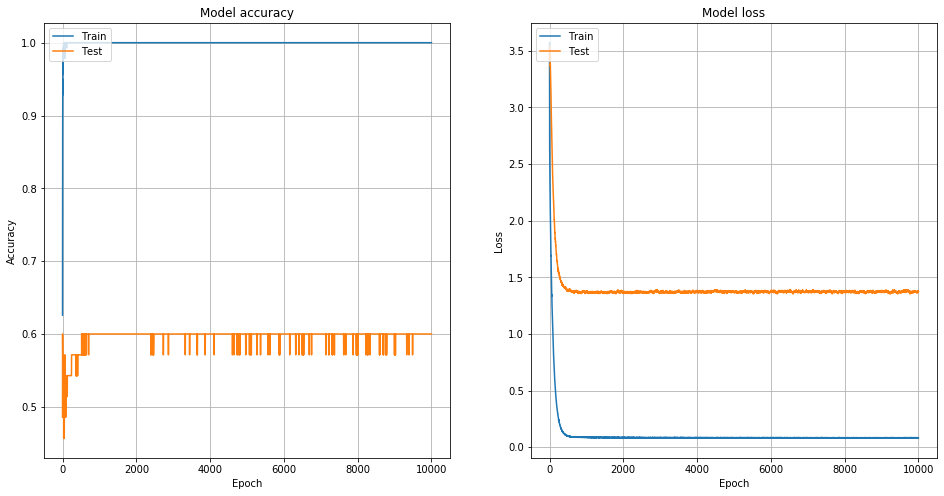

35/35 [==============================] - 0s 59us/step
Loss:1.375, Acc:0.6000


In [99]:
plot_history(history)
print("Loss:{:0.3f}, Acc:{:.4f}".format(*dnn.evaluate(X_valid,y_valid)))

Confusion matrix, without normalization
[[0.53333333 0.46666667]
 [0.35       0.65      ]]
Overall Accuracy: 0.6000


(<matplotlib.axes._subplots.AxesSubplot at 0x1a3aa173c8>, array([[ 8,  7],
        [ 7, 13]]))

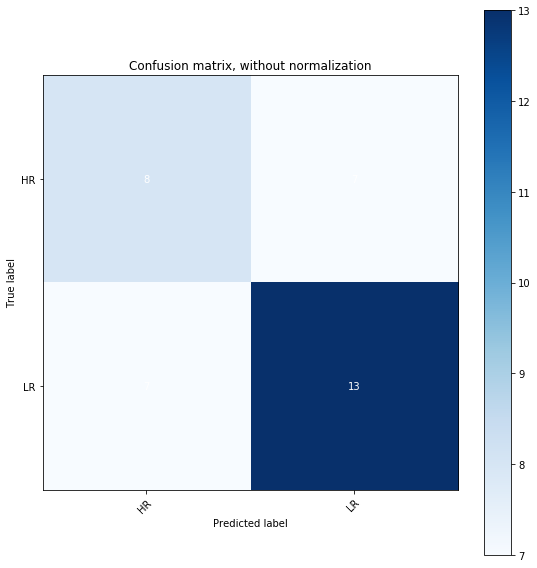

In [100]:
y_pred = np.round(np.ravel(dnn.predict(X_valid)))
plot_confusion_matrix(np.ravel(y_valid), y_pred, enc.categories_[1])

In [101]:
from sklearn.metrics import precision_score, make_scorer
prec_scorer = make_scorer(precision_score, pos_label=0)

precision_score(y_true=np.ravel(y_valid), y_pred=y_pred, pos_label=0)

0.5333333333333333

In [54]:
# np.ravel(dnn.predict(X_valid))

### Cross Validating

In [57]:
# Separating a hold out set that will be used for validation of the pipeline
train_data, train_labels, test_data, test_labels = split_valid(data, risk_labels, valid_size=0.2)

In [58]:
reducer = umap.UMAP(random_state=42,
                    n_components = 10,
                    n_neighbors=125,
                    min_dist=0)

In [69]:
dnn = build_dnn(num_features=data.shape[1], num_labels=1, activation="relu")
pipeline = ClusterPipeline(dnn, [train_data, train_labels], [test_data, test_labels],
                           target_class=0, reducer=reducer, softmax=False)

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:3.150, Acc:1.0000
Prediction Accuracy
14/14 [==============================] - 0s 3ms/step
Scores on data set: loss=4.191 accuracy=0.5714
Fold Correct: 8
Running worker: 1
Fold: 1 -> Loss:3.184, Acc:0.9840
Prediction Accuracy
14/14 [==============================] - 0s 44us/step
Scores on data set: loss=3.483 accuracy=0.6429
Fold Correct: 9
Running worker: 2
Fold: 2 -> Loss:3.152, Acc:0.9920
Prediction Accuracy
14/14 [==============================] - 0s 37us/step
Scores on data set: loss=3.686 accuracy=0.6429
Fold Correct: 9
Running worker: 3
Fold: 3 -> Loss:3.185, Acc:1.0000
Prediction Accuracy
14/14 [==============================] - 0s 52us/step
Scores on data set: loss=3.604 accuracy=0.6429
Fold Correct: 9
Running worker: 4
Fold: 4 -> Loss:3.187, Acc:0.9840
Prediction Accuracy
14/14 [==============================] - 0s 63us/step
Scores on data set: loss=3.569 accuracy=0.6429
Fold Correct: 9
Running worker: 5
Fold: 5

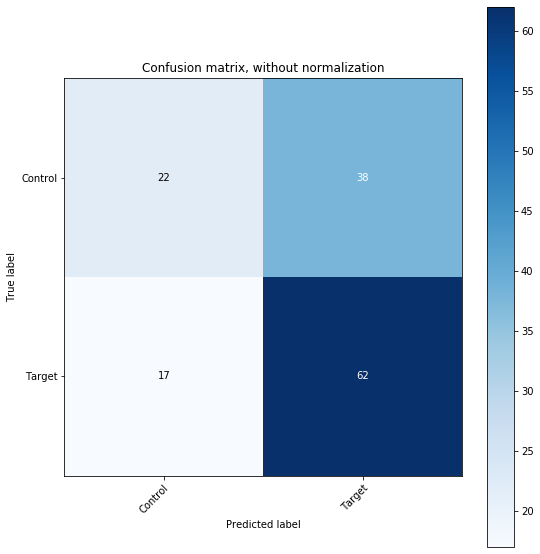

In [70]:
cm = pipeline.train_model(batch_size=5, epochs=500, cross_validation=True, parallel=False, verbose=0)

In [71]:
from sklearn.preprocessing import MinMaxScaler
reducer = umap.UMAP(random_state=42,
                    n_components = 10,
                    n_neighbors=5,
                    min_dist=0)

pipeline.reducer_pipeline = Pipeline([
            ("umap", reducer),
            ("scaler",  MinMaxScaler())
        ])

_, correct_pred_idxs = pipeline.train_clusterer(plot=False, class_label = 0)
print("Clusters Found:", max(pipeline.clusterer.labels_)+1)

LRP Shape:  (22, 345)
Cluster Search Space: range(2, 8)
Minimum Size:
Clusters                  (4, 4)
Noise                     (2, 2)
Halkidi                   (2, 2)
Halkidi-Filtered Noise    (2, 2)
dtype: object
Clusters Found: 3


In [79]:
# TODO: Put into helper.py

def plot_3d_lrp(lrp, colors=[], labels=[]):
    
    if lrp.shape[1] > 3:

        embedding_pipeline = Pipeline([
            ("reducer", umap.UMAP(random_state=42,
                            n_components = 3,
                            n_neighbors=3,
                            min_dist=0)),
           ("scaler", MinMaxScaler())
        ])
        embedding_pipeline.fit(lrp)
        embedding = embedding_pipeline.transform(lrp)
    else:
        embedding = lrp
            

    emb3d = go.Scatter3d(
        x=embedding[:,0],
        y=embedding[:,1],
        z=embedding[:,2],
        mode="markers",
        name="Training",
        marker=dict(
            size=5,
            color=colors,
            colorscale="Rainbow",
            opacity=0.8,
            showscale=True
        ),
        text=labels
    )

    layout = go.Layout(
        title="3D LRP Embedding",
        autosize=False,
        width=1200,
        height=1000,
        paper_bgcolor='#F5F5F5',
    #     template="plotly"
    )

    data=[emb3d]

    fig = go.Figure(data=data, layout=layout)
    # fig.update_layout(template="plotly")  /

    iplot(fig, filename='lrp-3d-scatter.html')

In [80]:
reindexed_labels = train_labels.iloc[pipeline.testing_idxs]
correct_idxs = pipeline.correct_preds_bool_arr

_correct=analysis_labels.loc[reindexed_labels[correct_idxs].index]
correct_HR = _correct[_correct["Risk"]=="HR"]

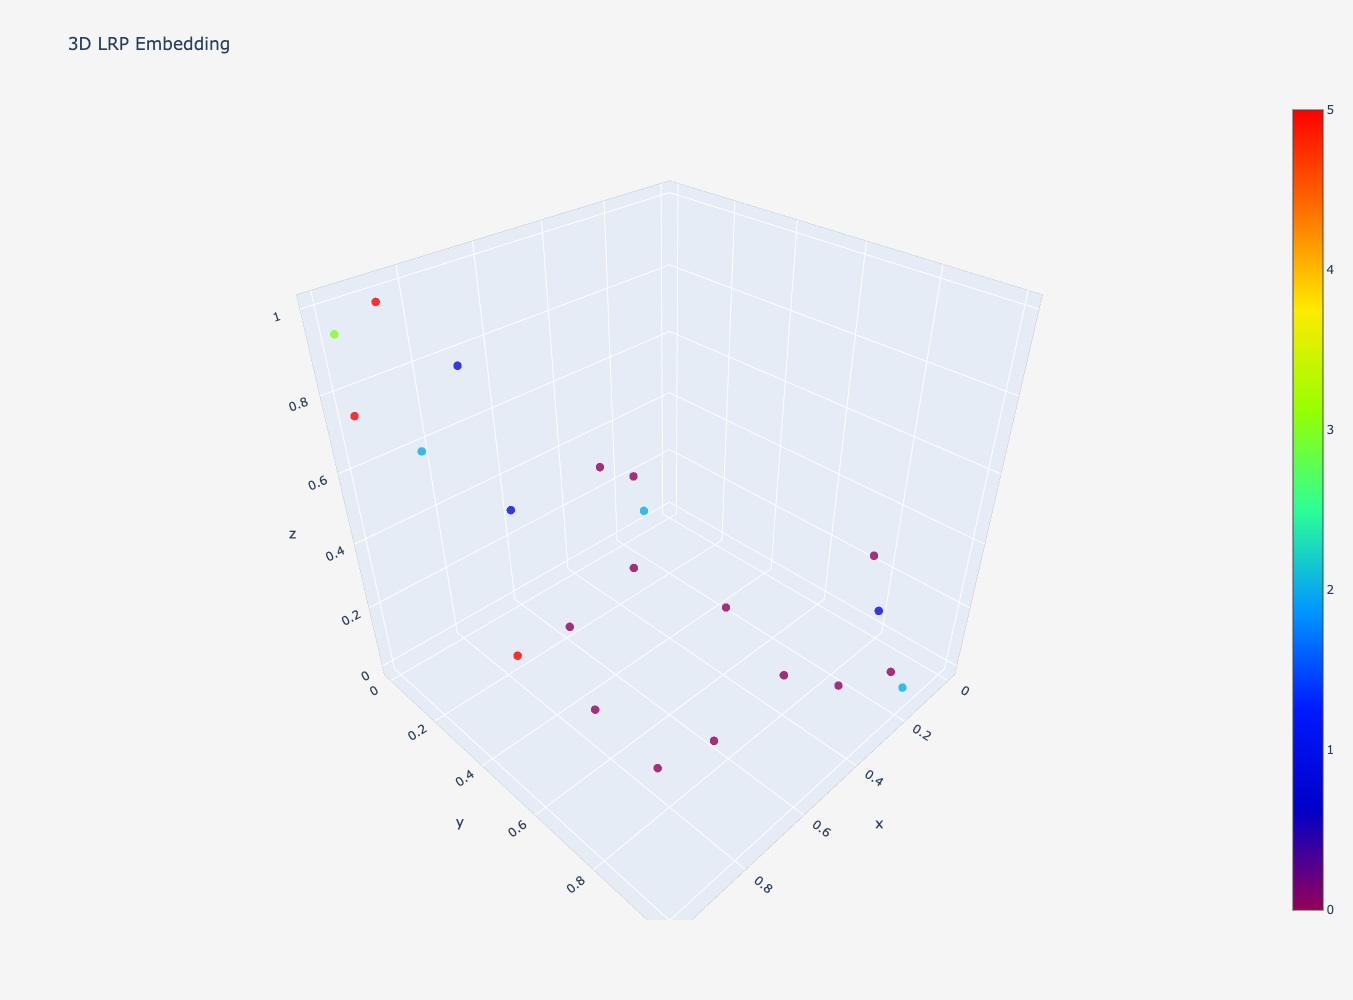

In [81]:
plot_3d_lrp(pipeline.training_lrp, colors=enc.transform(correct_HR)[:,0], labels=correct_HR["ASD_DX_group"])